# Term Analysis
This Jupyter Notebook, written in the R programming langauge, visualizes the changes to keywords on websites. As input, it takes a set of matrices produced by our page-scraping script [here](https://github.com/edgi-govdata-archiving/web_monitoring_research/blob/main/ctrl-f.py), where each column represents a term of interest (e.g. "climate change"), each row represents a page (e.g. "epa.gov/climatechange") and the cell value is the count of the term on that page. The script analyzes these results and generates figures.

## Load some extra code to help us
Run the code below by clicking "Play". It will load in some "libraries" of supplemental code to help us conduct our analysis and create figures.

In [1]:
library(readr)
library(dplyr)
library(ggplot2)
install.packages("ggrepel")
library(ggrepel)
options(warn = -1)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



## Load the data
Here, we'll load in the counts we made of key terms as they were mentioned on US federal environmental agency websites during the Obama era and during the Trump era.

In [39]:
# Load in the first timeframe's data - in this case, Obama era counts
first <- read_csv("https://raw.githubusercontent.com/edgi-govdata-archiving/web_monitoring_research/main/data/obama_count.csv", col_names = TRUE) 
# Load in the second timeframe's data - in this case, Trump era counts
second <- read_csv("https://raw.githubusercontent.com/edgi-govdata-archiving/web_monitoring_research/main/data/trump_count.csv", col_names = TRUE) 

# Convert missing values (999) due to WM error to NAs
first[first==999] <- NA
second[second==999] <- NA

# Load in a CSV that has the list of terms - this is for formatting outputs
terms<-read_csv("https://raw.githubusercontent.com/edgi-govdata-archiving/web_monitoring_research/main/data/terms.csv", col_names = FALSE) 
terms<-tolower(terms)

# Load in a CSV that has a list of the URLs, organizations, etc.
urls <- read_csv("https://raw.githubusercontent.com/edgi-govdata-archiving/web_monitoring_research/main/data/counted_urls.csv", col_names=TRUE) 
# Slashes removed means trailing slashes - those at the end of some urls - have been removed

# This does matrix math to calculate, for each page and term, the change (positive, negative, or zero) in usage
combined<-second-first 


── Column specification ────────────────────────────────────────────────────────
cols(
  .default = col_double()
)
ℹ Use `spec()` for the full column specifications.



── Column specification ────────────────────────────────────────────────────────
cols(
  .default = col_double()
)
ℹ Use `spec()` for the full column specifications.



── Column specification ────────────────────────────────────────────────────────
cols(
  .default = col_character()
)
ℹ Use `spec()` for the full column specifications.



── Column specification ────────────────────────────────────────────────────────
cols(
  `url - o` = col_character(),
  `shortened url - o` = col_character(),
  `captured url - 0` = col_character(),
  `url - t` = col_character(),
  `shortened url - t` = col_character(),
  `final captured url - t` = col_character(),
  domain = col_character(),
  org = col_character()
)




## Process these counts
This step is required. We attempted to count terms on nearly 40,000 pages that we had previously identified, but not all of these pages are actually meaningful to exam. So, we exclude some of them in this step. 

In [40]:
# Handle duplicated URLs - find their "index"....
duplicates<-which(duplicated(urls$`url - o`) | duplicated(urls$`url - o`, fromLast = TRUE)) #url duplicates
duplicates.short<-which(duplicated(urls$`shortened url - o`) | duplicated(urls$`shortened url - o`, fromLast = TRUE))#shortened url duplicates
duplicates<-c(duplicates, duplicates.short)
duplicates<-unique(duplicates)

#....and then filter away
first<-first[-c(duplicates),]
second<-second[-c(duplicates),]
combined<-combined[-c(duplicates),]
urls<-urls[-c(duplicates),]

# Handle pages we don't want or can't process (e.g. Jan 2017 snapshots, blogs, Spanish-language pages)
pages.snapshots<-grep('snapshot', urls$`url - o`)
pages.edu<-grep('edu/', urls$`url - o`)
pages.news<-grep('news', urls$`url - o`)
pages.blog<-grep('blog', urls$`url - o`)
pages.News<-grep('News', urls$`url - o`)
pages.espanol<-grep('espanol', urls$`url - o`)

# Relevant to depth analysis. Run this with different configurations of `which(pages.length > X)` You will have to load the original data again (previous cell) each time.
pages.length<-sapply(gregexpr("/", urls$`url - o`), length) # gets the number of slashes in each url (a proxy for importance/relevance)
pages.length<-which(pages.length > 6)
# default is > 6 which ultimately removes pages with greater than 6 slashes.
# for page depth analysis, MORE VISIBLE: > 4 gets "2 or less". Gets rid of urls with 5 or more slashes. 
# for page depth analysis, LESS VISIBLE: < = 4 gets "3 or more". Gets rid of urls with 4 or fewer.

dump<-c(pages.snapshots,pages.edu, pages.news,pages.blog, pages.News, pages.espanol, pages.length)
dump<-unique(dump)

first<-first[-c(dump),]
second<-second[-c(dump),]
combined<-combined[-c(dump),]
urls<-urls[-c(dump),]

# Make comparisons only on snapshots available in both timeframes
snaps<-which(!is.na(urls$`captured url - 0`) & !is.na(urls$`final captured url - t`))
first<-first[c(snaps),]
second<-second[c(snaps),]
combined<-combined[c(snaps),]
urls<-urls[c(snaps),]

# Save count data by visibility, for creating Figures 8 and 9
#first_moreviz <- first
#second_moreviz <- second
#combined_moreviz <- combined
#urls_moreviz <- urls

#first_lessviz <- first
#second_lessviz <- second
#combined_lessviz <- combined
#urls_lessviz <- urls

## Debug
We want to verify that we have loaded the data correctly. Run the following cell, and if it outputs "0", we are good to go!

In [41]:
errors=0
for (i in 1:nrow(urls)) {
  if (tolower(urls$`shortened url - o`[i]) != tolower(urls$`shortened url - t`[i])){
    errors<-errors+1
    print(i)
  }
}
errors

[1] 0

## Take a look at the data
Here is a sample of what the data we have look like. This is the change between 2016 and 2020 for the first/last 20 pages and first/last few terms in our analysis.

In [5]:
combined.full<-cbind(urls[c(1,3,6,8)], combined) 
combined.full

,url - o,captured url - 0,final captured url - t,org,adaptation,agency mission,air quality,anthropogenic,benefits,brownfield,⋯,sensible regulations,state,storms,sustainability,toxic,transparency,unconventional gas,unconventional oil,water quality,wildfires
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2,http://www3.epa.gov/climatechange/science/,http://web.archive.org/web/20160229155838id_/http://www3.epa.gov/climatechange/science/,http://web.archive.org/web/20200101053534id_/https://www.epa.gov/climatechange/science/,EPA,-4,0,0,0,-4,0,⋯,0,-2,0,0,0,0,0,0,0,0
3,https://www3.epa.gov/enviro/,http://web.archive.org/web/20160629201908id_/https://www3.epa.gov/enviro/,http://web.archive.org/web/20200604133529id_/https://www.epa.gov/enviro,EPA,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
4,https://www3.epa.gov/climatechange/,http://web.archive.org/web/20160621202353id_/https://www3.epa.gov/climatechange/,http://web.archive.org/web/20200104172744id_/https://www.epa.gov/climatechange,EPA,0,0,0,0,-4,0,⋯,0,-1,0,0,0,0,0,0,0,0
5,https://www3.epa.gov/climatechange,http://web.archive.org/web/20160621202353id_/https://www3.epa.gov/climatechange/,http://web.archive.org/web/20200104172744id_/https://www.epa.gov/climatechange,EPA,0,0,0,0,-4,0,⋯,0,-1,0,0,0,0,0,0,0,0
6,https://www3.epa.gov/enviro/facts/igms/search.html,http://web.archive.org/web/20160612081906id_/https://www3.epa.gov/enviro/facts/igms/search.html,http://web.archive.org/web/20200101042315id_/https://www3.epa.gov/enviro/facts/igms/search.html,EPA,0,0,0,0,0,-2,⋯,0,3,0,1,2,0,0,0,3,0
8,https://www3.epa.gov/enviro/facts/multisystem.html,http://web.archive.org/web/20160612091334id_/https://www3.epa.gov/enviro/facts/multisystem.html,http://web.archive.org/web/20200101042321id_/https://www3.epa.gov/enviro/facts/multisystem.html,EPA,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
9,http://www3.epa.gov/enviro/myenviro/,http://web.archive.org/web/20160314204702id_/http://www3.epa.gov/enviro/myenviro/,http://web.archive.org/web/20200101042324id_/https://www3.epa.gov/enviro/myenviro/,EPA,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
10,https://www3.epa.gov/enviro/facts/tsca/tsca_search.html,http://web.archive.org/web/20160612081810id_/https://www3.epa.gov/enviro/facts/tsca/tsca_search.html,http://web.archive.org/web/20200101042327id_/https://www3.epa.gov/enviro/facts/tsca/tsca_search.html,EPA,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
11,https://www3.epa.gov/enviro/facts/rcrainfo/search.html,http://web.archive.org/web/20160418213634id_/https://www3.epa.gov/enviro/facts/rcrainfo/search.html,http://web.archive.org/web/20200101042329id_/https://www3.epa.gov/enviro/facts/rcrainfo/search.html,EPA,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0


## Summary statistics

In [8]:
cat("\n Number of pages with Wayback Machine snapshots available for both timeframes: ", nrow(combined))

i=9 # "Climate Change"

df<-data.frame(first[,i], second[,i]) # Filter to only the Climate Change column, putting both Obama and Trump data in the same frame
colnames(df)<-c("obama", "trump") 
zero<- df[which(df$obama == 0 & df$trump == 0),] 
change<-df[which(df$obama > 0 | df$trump > 0),] # Keep pages where Obama > 0 OR Trump > 0. Remove 0/0. 

cat("\n Number of these pages where 'climate change' was never mentioned: ", nrow(zero))

cat("\n Number of pages where 'climate change' was mentioned at least once in one or both timeframes: ", nrow(change))

cat("\n Number of pages where 'climate change' was increased or decreased: ", nrow(change) - nrow(change[which(change$obama == change$trump),]))

cat("\n Overall percent change in use of 'climate change': ", 100*(sum(combined[i])/sum(first[i])))


 Number of pages with Wayback Machine snapshots available for both timeframes:  8813
 Number of these pages where 'climate change' was never mentioned:  6728
 Number of pages where 'climate change' was mentioned at least once in one or both timeframes:  2085
 Number of pages where 'climate change' was increased or decreased:  1251
 Overall percent change in use of 'climate change':  -38.59386

## Figure 3
The following code creates Figure 3. Changes to the use of “climate change” across the federal agency websites in our sample that mentioned the term in 2016 and/or 2020. The x axis shows the counts of "climate change" on a page in 2016, the y axis shows the difference in that count between 2016 and 2020 on a given page. Each bar represents a unique set of 2016->2020 page count shifts, e.g. 10 to 6 uses. The transparency of each bar reflects the number of pages that experienced that shift: the darker the bar, the more pages that started with that particular count of "climate change" in 2016 and added or removed that many instances of the term.

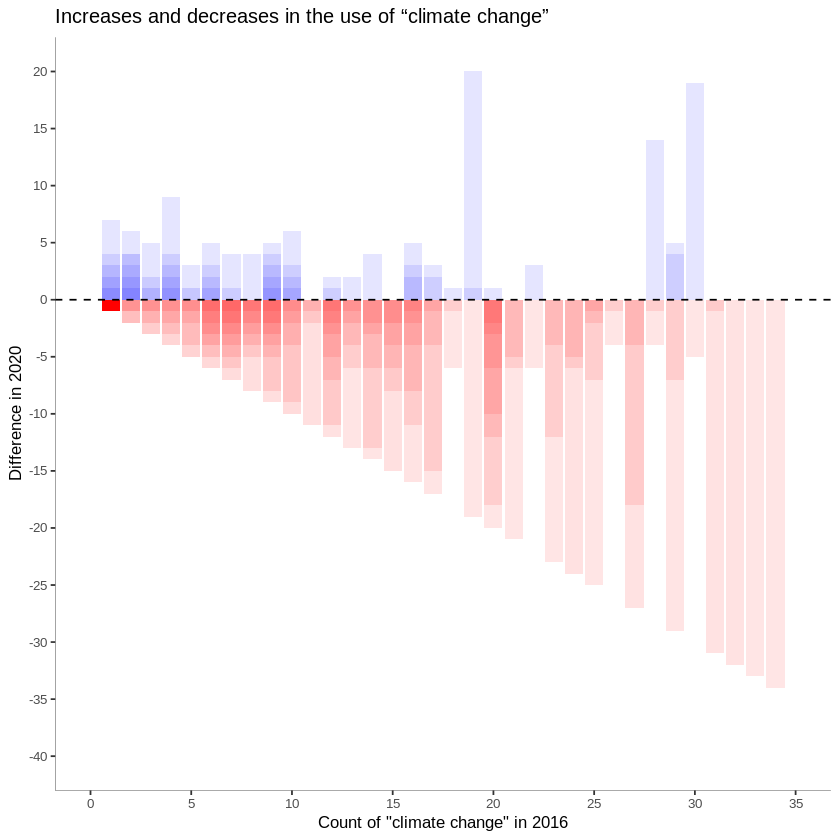

In [9]:
# This could be done in a loop to compare multiple terms, but for our purposes, we'll look at "climate change"
i=9 # "Climate Change"

df<-data.frame(first[,i], second[,i]) # Filter to only the Climate Change column, putting both Obama and Trump data in the same frame
colnames(df)<-c("obama", "trump") 
use<-which(df$obama > 0 | df$trump > 0) # REMOVE ZEROS
df<-df[c(use),]
same<-which(df$obama == df$trump) # For this figure, we don't want to plot pages that didn't change
df<-df[-c(same),]

df$change <- df$trump-df$obama # Calculate a new column, the change between 2016 and 2018
# Count of unique count pairings by URLs. (1,2 | 1,4 | 3,1 | etc.) How many of each change 1->2, 1->4, 3->1 are there?
df.unique<-df %>% group_by(obama, change)%>%mutate(chg = sum(change), count=n()) 
df.unique<-unique(df.unique)

pal <- c("red", "blue") # pallette for increases and decreases

# Create the plot
p <- ggplot(df.unique, aes(obama, change, alpha=count, fill=change>0)) +
    geom_bar(stat='identity', position='identity') +
    scale_fill_manual(values=pal) +
    labs(title = 'Increases and decreases in the use of “climate change”', x='Count of "climate change" in 2016', y='Difference in 2020')+
    theme(text=element_text(size=10), panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
            plot.background=element_rect(fill='white'), panel.background = element_rect(fill='white'), 
            legend.position="none", axis.line = element_line(colour = "black", size=.1)) +
    scale_y_continuous(limits=c(-40,20), breaks=seq(-100, 80, 5)) +
    scale_x_continuous(limits=c(0,35), breaks=seq(0, 150, 5)) + 
    geom_hline(yintercept=0, linetype="dashed", color = "black")
p
ggsave(filename = "fig3.png", p,
       width = 10, height = 8, dpi = 300, units = "in", device='png') # Saves the figure to the "Files" in Colab

## Figure 4
Figure 4 is a set of "small multiples" which shows pages that saw changes to both “resilience” (y-axis) and “climate change” (x-axis). Arrows indicate the directionality of change between 2016 and 2018. One "multiple" shows pages on which “climate change” decreased and “resilience” increased; another shows pages on which “climate change” decreased and “resilience” decreased. In each chart, both the x and y axes run from 0 to 22.

The first cell below prepares the data for plotting; the second actually creates the small multiples.

In [10]:
# Again, this could be done in a loop to compare multiple terms, but for our purposes, we'll look at just "climate change"
# and resilience
i=9 #"Climate Change"
j=43 #"Resilience"

col<-first[c(i,j)] # From the first timeframe, the term count
tcol<-second[c(i,j)] # From the second timframe, the term count

urlsDump<-urls # A temporary variable for our URLs
orgsDump<-data.frame(urls$org) # A temporary variable for our URLs (by agency)

# Shed zeros - We won't count pages if both terms weren't originally used on the page in the Obama-era.
zeros<-which(col[,1]==0 & col[,2]==0)
col<-col[-c(zeros),]
tcol<-tcol[-c(zeros),]
urlsDump<-urlsDump[-c(zeros),1]
orgsDump<-orgsDump[-c(zeros),1]

combo<-cbind(urlsDump, col, tcol, orgsDump)
colnames(combo)<-c("url", "o_CC", "o_R", "t_CC", "t_R", "orgs") 

# Now subset data to prepare for small multiples
# NOTE: BOTH TERMS HAVE TO CHANGE....i.e. no flat or vertical lines.
NE <- which(combo[,2]-combo[,4]<0 & combo[,3]-combo[,5] <0)
SE <- which(combo[,2]-combo[,4]<0 & combo[,3]-combo[,5] >0)
SW <- which(combo[,2]-combo[,4]>0 & combo[,3]-combo[,5] >0)
NW <- which(combo[,2]-combo[,4]>0 & combo[,3]-combo[,5] <0)
#E<-which(combo[,2]-combo[,4]<0 & combo[,3]-combo[,5] == 0) 
#N<-which(combo[,2]-combo[,4]==0 & combo[,3]-combo[,5] < 0) 
#S<-which(combo[,2]-combo[,4]==0 & combo[,3]-combo[,5] > 0) 

directions<-list(NE,SE,SW,NW)

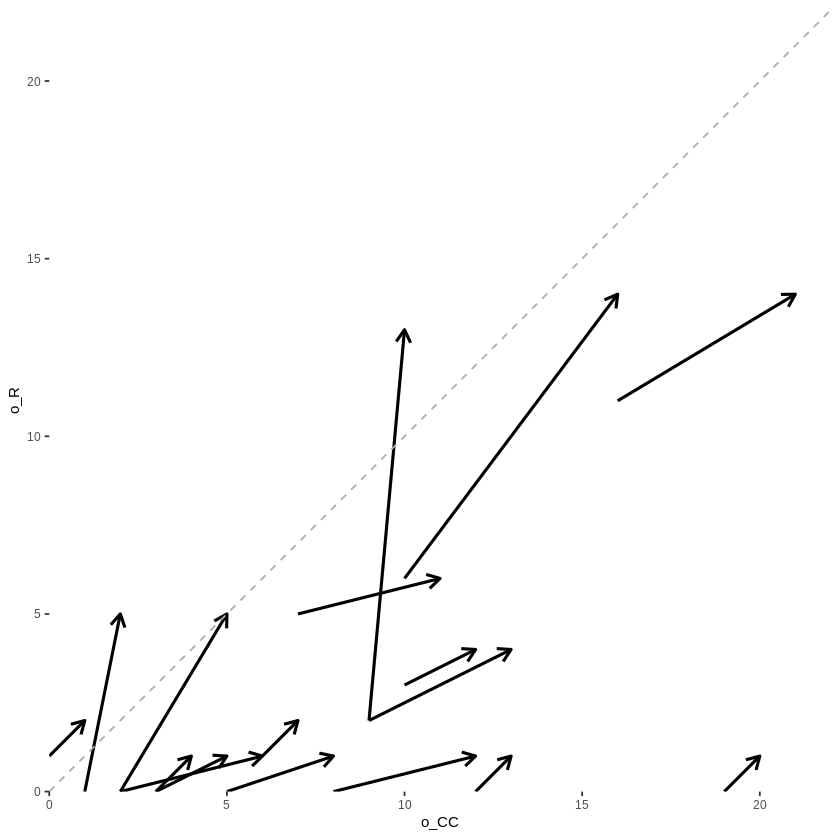

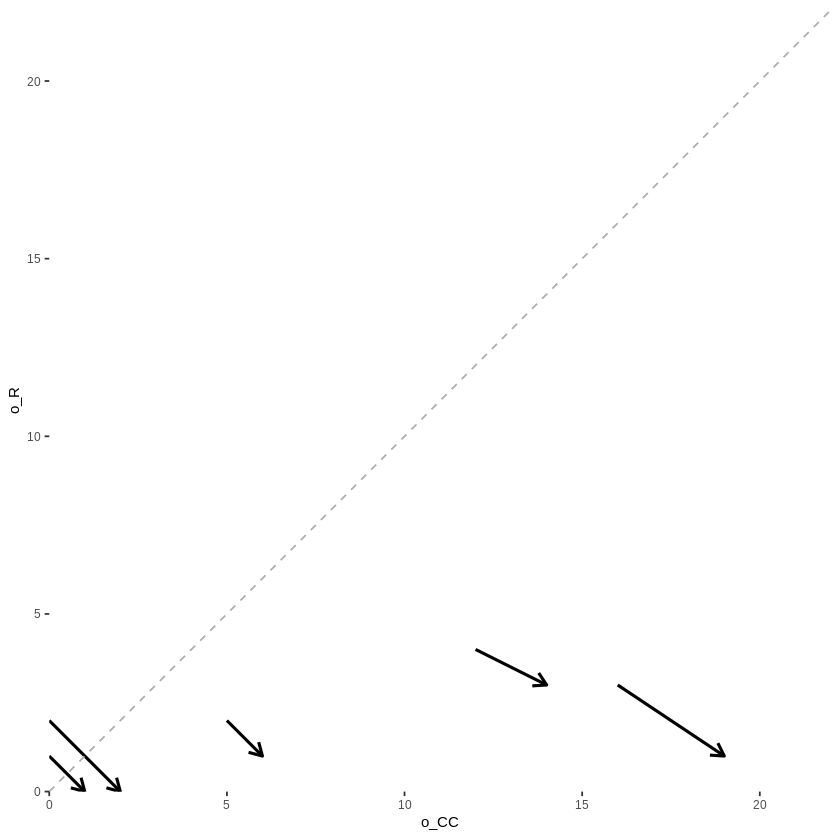

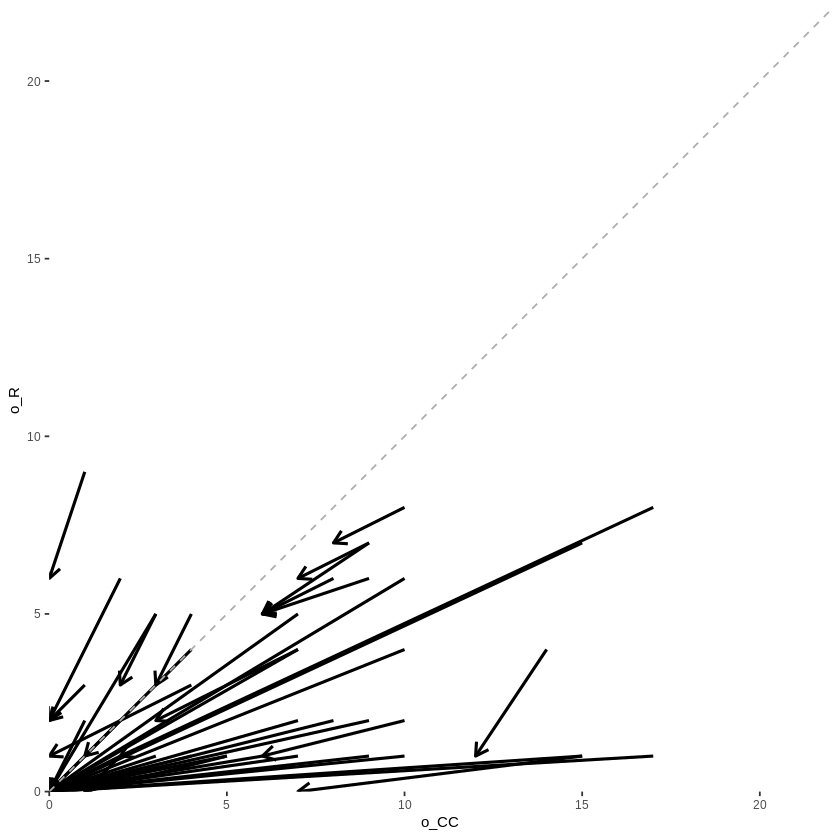

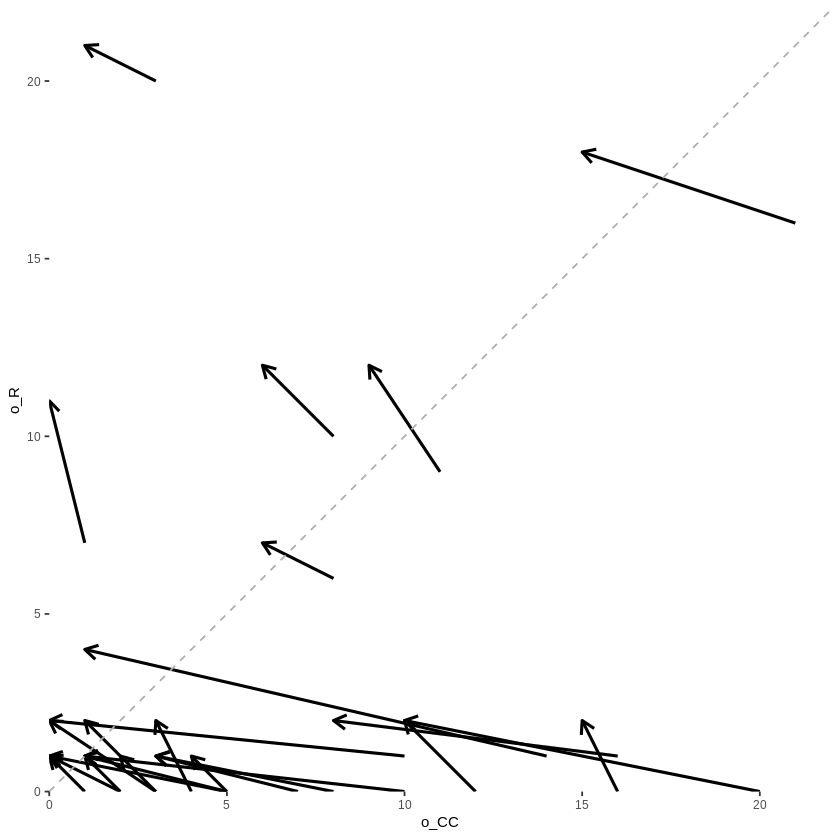

In [11]:
# Create small multiples
times = 1
for (d in directions){
    
    combo<-cbind(urlsDump, col, tcol, orgsDump)
    colnames(combo)<-c("url", "o_CC", "o_R", "t_CC", "t_R", "orgs") 

    combo<-combo[c(d),] # Focus on the current direction
    
    combo<-combo[,c(2:5)] # Get rid of unnecessary columns (URL, agency, etc.)
    c<-combo %>% group_by(o_CC, o_R, t_CC, t_R) %>%mutate(count = n())
    c<-unique(c)
    
    # Draw arrows
    p<-ggplot(c,aes(x = o_CC,y = o_R))+
    geom_point(aes(x = o_CC,y = o_R), size=0, color="white") + 
    geom_point(aes(x = t_CC,y = t_R), size=0, color="white") +
    scale_y_continuous(limits=c(0,22), expand = c(0,0)) +
    scale_x_continuous(limits=c(0,22),expand = c(0,0)) + 
    #labs(x="Count of climate change", y="Count of resilience")+
    theme(aspect.ratio=1)+ 
    theme(text=element_text(size=9), panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
            panel.background = element_blank(), legend.position="none") + # , axis.line = element_line(colour = "grey68", size=.1)
    geom_segment(aes(x = o_CC,y = o_R,xend = t_CC,yend = t_R, size=3), color="black", arrow=arrow(angle = 30, length = unit(0.12, "inches"), ends = "last", type = "open")) + 
    geom_abline(intercept=0, slope=1, colour="grey68", linetype=2, size=.5) + scale_size(range = c(.1, 1.2),guide=FALSE)  
    
    print(p)
    ggsave(filename = paste0(times,"fig4.png"), p,
       width = 10, height = 8, dpi = 300, units = "in", device='png') # Saves the figures to the "Files" in Colab
    times = times + 1
}

## Figure 5
This figure shows the average per page use of the term “climate change” for each agency in our sample, in 2016 and 2020. The trend line represents no change (x = y). The x and y axes are square root scaled.

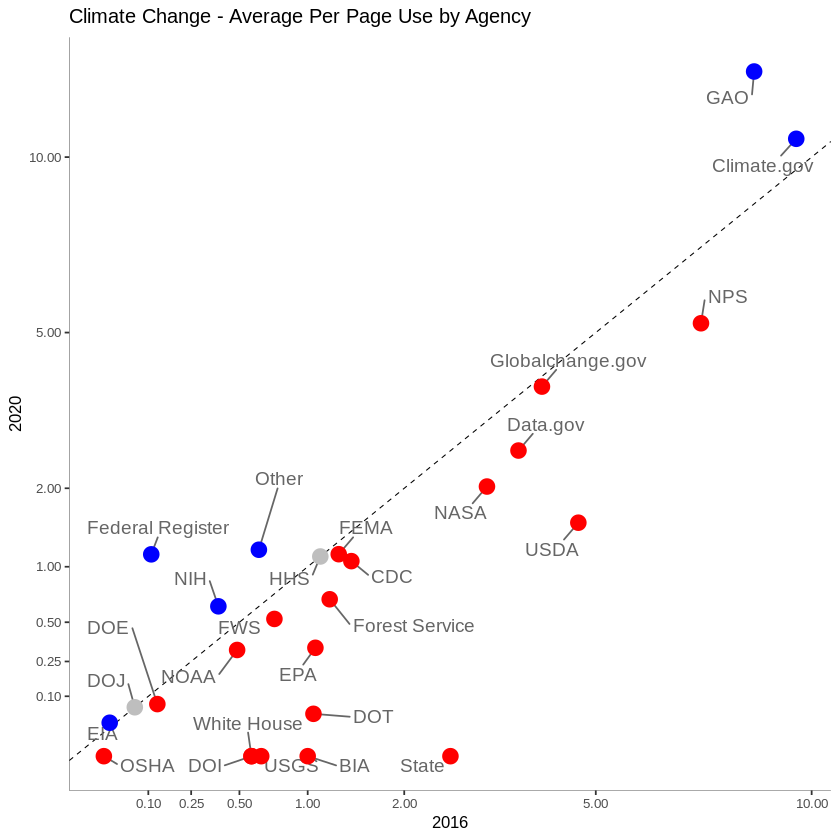

In [12]:
# This could be configured as a loop to go through each term but for our purposes here, we'll only look at "climate change"

i=9 # "Climate Change"

# Summarize all URLs by org (agency)
by.org<-urls%>% group_by(org) %>%summarise(num_of_pages=n()) 

# Report by agency and count
combined.url<-cbind(urls[c(1,3,6,8)], first[i], second[i], combined[i]) 
colnames(combined.url)<-c("url", "obama wm", "trump wm", "org", "before", "after","diff")

# Change by term
stats<-combined.url%>% group_by(org) %>%summarise(ObamaSum=sum(before), TrumpSum=sum(after), OCount=sum(before>0), TCount=sum(after>0))
stats<-merge(stats, by.org, by = "org")

# Visualize term data by agency - changes in average use
stats.viz<-stats
stats.viz$Obamadensity<-stats.viz$ObamaSum/stats.viz$num_of_pages #rate of use across all agency pages
#stats.viz$Obamaintensity<-stats.viz$ObamaSum/stats.viz$OCount #rate of use across the pages it was used on
stats.viz$Trumpdensity<-stats.viz$TrumpSum/stats.viz$num_of_pages #rate of use across all agency pages
#stats.viz$Trumpintensity<-stats.viz$TrumpSum/stats.viz$TCount #rate of use across the pages it was used on

# For colouring the markers
stats.viz$position[stats.viz$Trumpdensity- stats.viz$Obamadensity == 0] = "No Change"
stats.viz$position[stats.viz$Trumpdensity- stats.viz$Obamadensity > 0] = "Increase"
stats.viz$position[stats.viz$Trumpdensity- stats.viz$Obamadensity < 0] = "Decrease"

# Remove 0/0s for clarity
stats.viz <- stats.viz[-c(which(stats.viz$TrumpSum == 0 & stats.viz$ObamaSum == 0)),]

# Plot the figure
title<-("Climate Change - Average Per Page Use by Agency")
p <- ggplot(stats.viz, aes(x = Obamadensity,y = Trumpdensity, label = stats.viz$org))+
    geom_abline(intercept=0, slope=1, colour="black", size=.3, linetype="dashed") +
    geom_text_repel(colour='#666666', size = 4, box.padding = .75)+
    geom_point(aes(x = Obamadensity,y = Trumpdensity,  color=stats.viz$position), size=4) + 
    scale_x_sqrt(breaks=c(0, .1,.25, .5, 1, 2, 5, 10)) +
    scale_y_sqrt(breaks=c(0, .1,.25, .5, 1,2, 5, 10)) +
    labs(x="2016", y="2020", title=title) +
    scale_colour_manual(values = c("Red", "Blue", "Grey")) + 
    theme(text=element_text(size=10), panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
         plot.background=element_rect(fill='white'), panel.background = element_rect(fill='white'), 
         legend.position="none", axis.line = element_line(colour = "black", size=.1))
p
ggsave(filename = "fig5.png", p,
    width = 10, height = 8, dpi = 300, units = "in", device='png') # Saves the figure to the "Files" in Colab

## Figure 6
This figure shows the mean per page usage change on Cabinet vs Non-Cabinet agency websites, ordered left to right by our empirically driven expectations of decreases or increases in usage. Tan represents Non-Cabinet agencies; green represents Cabinet agencies. In general, Cabinet agencies removed terms more than Non-Cabinet agencies. Terms like “climate change” and “climate” were especially targeted for removal, while terms like “energy independence” and “sustainability” were added. Due to our sampling method, there is very little data for the use of “unconventional oil” and “unconventional gas” and no data for non-Cabinet agencies for the term “unconventional gas”. 

In the first cell, we process the data, separating it out by agency and ultimate cabinet status for each term. In the second, we create the chart.

In [13]:
climate_terms<-c("climate change", "climate", "greenhouse gases", "clean energy", 
                                "hydraulic fracturing", "adaptation", "air quality", "emissions", 
                                "resilience", "sustainability", "unconventional gas", "unconventional oil", 
                                "energy independence")
cabinet_final<-data.frame(Term=character(13), Average=double(13), Cabinet=character(13))
cabinet_final$Term<-climate_terms
cabinet_final$Cabinet<-c("cabinet")

nc_final<-cabinet_final
nc_final$Cabinet<-c("non-cabinet")

final<-rbind(cabinet_final, nc_final)

cabinet_agencies<-c('DOE', 'DOI', 'DOJ', 'DOT', 'EPA', 'HHS' ,'USDA', 'White House')

by.org<-urls%>% group_by(org) %>%summarise(num_of_pages=n())
by.org<-by.org[!(by.org$org == "Other"),] # Remove other agencies

for (agency in c("cabinet", "non-cabinet")){
    for (term in climate_terms){
        i<-match(term, terms)
        
        d<-cbind(urls[c(1,3,6,8)], first[i], second[i], combined[i])
        colnames(d)<-c("url", "obama wm", "trump wm", "org", "before", "after","diff")
        
        s<-d%>% group_by(org) %>%summarise(Diff = sum(after-before), ObamaSum=sum(before), TrumpSum=sum(after), OCount=sum(before >0 ), TCount=sum(after>0))
        s<-merge(s, by.org, by = "org")

        s$cabinet<- ifelse(s$org %in% cabinet_agencies, "cabinet", "non-cabinet")
        a<-s[which(s$cabinet == agency),]
        avg<-sum(a$Diff)/sum(a$OCount) # Need to limit to Obama > 0 to do % change calculation
        final[(which(final$Term == term & final$Cabinet == agency)),2]<-avg  
    }
}

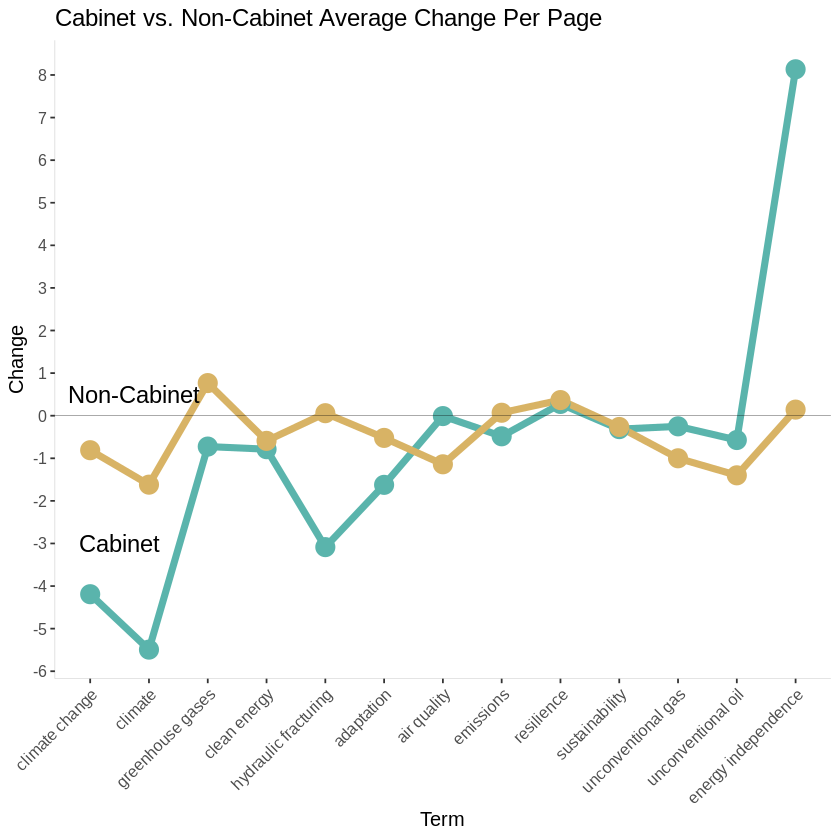

In [20]:
# Order our x axis
final$Term<-factor(final$Term, levels=c("climate change", "climate", "greenhouse gases", "clean energy", 
                                "hydraulic fracturing", "adaptation", "air quality", "emissions", 
                                "resilience", "sustainability", "unconventional gas", "unconventional oil", 
                                "energy independence"))

# Create the plot
p<-ggplot(data=final, aes(x=Term, y=Average, group=Cabinet)) +
  geom_line(aes(color=Cabinet), size=2)+
  geom_point(aes(color=Cabinet), size=5) + 
  geom_abline(intercept=0, slope=0, colour="black", size=.1) +
  theme(text=element_text(size=12), 
        axis.text.x = element_text(angle = 45, hjust = 1), 
        panel.grid.major = element_blank(), 
        panel.grid.minor = element_blank(),
        panel.background = element_blank(), 
        legend.position="none",
        axis.line = element_line(colour = "grey68", size=.1)) +
  labs(title="Cabinet vs. Non-Cabinet Average Change Per Page", y="Change") +
  scale_color_manual(values=c('#5ab4ac','#d8b365')) +
  annotate("text", label = "Cabinet", x = 1.5, y = -3, size = 5, colour = "black")  +
  annotate("text", label = "Non-Cabinet", x = 1.75, y = .5, size = 5, colour = "black") +
  scale_y_continuous( breaks=seq(-9, 9, by=1))
p
ggsave(filename ="fig6.png", p,
    width = 10, height = 8, dpi = 300, units = "in", device='png') # Saves the figure to the "Files" in Colab

## Figure 7
The range of changes to climate-related terms in Cabinet and Non-Cabinet agency websites, ordered left to right by our empirically-driven expectations of decreases or increases in usage. Tan circles represent Cabinet agency pages; green circles represent Non-Cabinet agency pages. Circle size indicates the number of pages experiencing that degree of change. Cabinet agencies tended to have a larger range of term usage changes than non-Cabinet agencies, and tended to have more pages with more decreased usage for most climate-related terms. 

In the first cell, we process the data, separating it out by agency and ultimate Cabinet status for each term. In the second, we create the chart.

In [21]:
final<-data.frame(change=integer(), term=character(), cabinet=character())

for (term in climate_terms){
    i<-match(term, terms)
    
    d<-cbind(urls[c(1,8)], first[i], combined[i])
    colnames(d)<-c("url","org", "obama", "change")
    
    d<-d[which(d$obama > 0),] # Looking only at pages that originally used the term
    d$term<-terms[i]
    d$cabinet<- ifelse(d$org %in% cabinet_agencies, "cabinet","non-cabinet")
    
    d<-d[,-c(2, 3)]
    
    final<-rbind(final, d)
}

final<-final[order(final$change),] # Sort by amount of change
final<-final[-1,] # Remove an outlier - http://scenarios.globalchange.gov/images
final<-final[order(final$change, decreasing=TRUE), ] # Sort by amount of change
final<-final[-1,] # Remove an outlier from "Other" agency - http://ncics.org/publications/

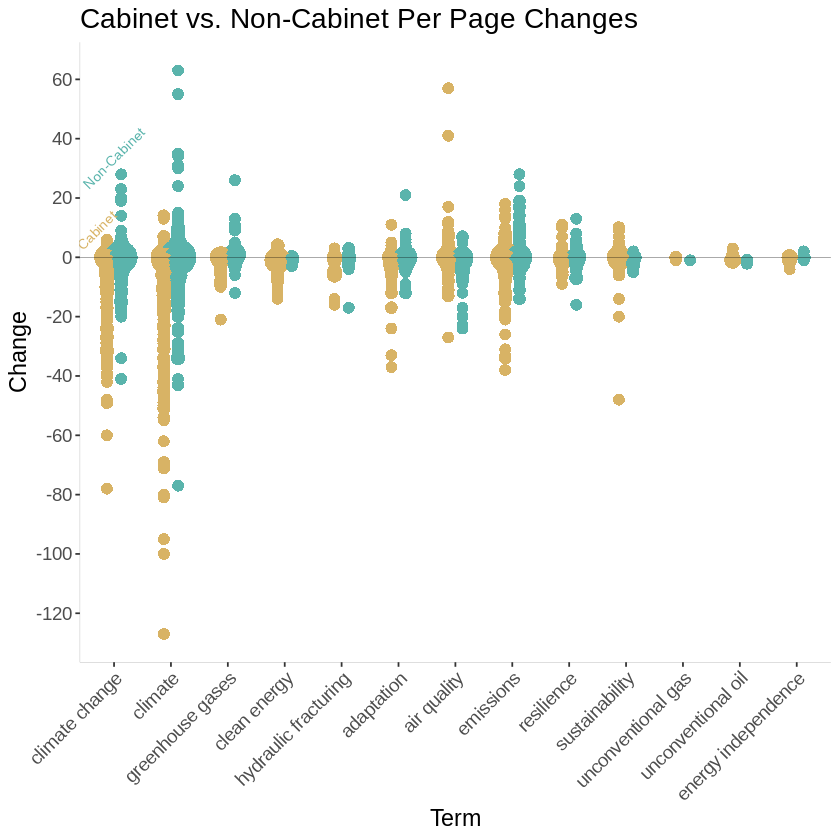

In [24]:
# Order our x-axis
final$term <- factor(final$term, levels=c("climate change", "climate", 
                                        "greenhouse gases", "clean energy", "hydraulic fracturing", 
                                        "adaptation", "air quality", "emissions", "resilience", "sustainability", 
                                        "unconventional gas", "unconventional oil", "energy independence"))

# How many of each change 1->2, 1->4, 3->1 are there?
f <- final %>% group_by(term, change, cabinet)%>%mutate(count=n())

p <- ggplot(f, aes(x=term, y=change)) +
  geom_point(aes(shape="20", color=cabinet, size=count), na.rm=TRUE, position=position_dodge(.5))+
  scale_size(range = c(3, 10)) +
  geom_abline(intercept=0, slope=0, colour="black", size=.1) +
  theme(text=element_text(size=14), axis.text.x = element_text(angle = 45, hjust = 1),
          panel.grid.major = element_blank(), 
          panel.grid.minor = element_blank(),
          panel.background = element_blank(), 
          legend.position="none", 
          axis.line = element_line(colour = "grey68", size=.1)) +
  labs(title="Cabinet vs. Non-Cabinet Per Page Changes", y="Change", x="Term") +
  scale_color_manual(values=c('#d8b365','#5ab4ac')) +
  annotate("text", angle = 45, hjust=1, label = "Cabinet", x = 1, y = 15, size = 3, colour = "#d8b365")  +
  annotate("text", angle = 45, hjust=1, label = "Non-Cabinet", x = 1.5, y = 43, size = 3, colour = '#5ab4ac') +
  scale_y_continuous( breaks=seq(-140, 80, by=20))
p
ggsave(filename = "fig7.png", p,
    width = 10, height = 8, dpi = 300, units = "in", device='png') # Saves the figure to the "Files" in Colab

## Heads up! 
In order to create the final two figures (8 and 9), be sure to reload the data again and run the "Process these counts" cell, changing the `pages.length<-which(pages.length > 6)` line accordingly (you will need to do this twice to get the more visible pages and the less visible ones).

## Figure 8
This figure shows changes in the use of key terms by page visibility. More opaque bars represent more visible pages; more transparent bars represent less visible ones. Blue indicates additions; red represents removals.

In the first cell, we process the data. In the second, we create the chart.

In [35]:
climate_terms<-c("climate change", "climate", "greenhouse gases", "clean energy", 
                                "hydraulic fracturing", "adaptation", "air quality", "emissions", 
                                "resilience", "sustainability", "unconventional gas", "unconventional oil")
# Excludes "energy independence" because it is an outlier - 850% increase, but only across a handful of pages

high_depth_final<-data.frame(Term=character(), Visibility=character(), Percent=double(), Viz=double())

low_depth_final<-high_depth_final # Copy to create the low depth version

final<-rbind(high_depth_final, low_depth_final)

# more visible
for (term in climate_terms){
    i<-match(term, terms)
    
    d<-cbind(urls_moreviz[c(1,8)], first_moreviz[i], combined_moreviz[i])
    colnames(d)<-c("url","org", "obama", "change")
    
    r<-data.frame(Term=character(1), Visibility=character(1), Percent=double(1), Viz=double(1)) # Temporary data frame to paste to the final output
    r$Visibility <- c("more visible pages")
    r$Percent <- (sum(d$change)/sum(d$obama))*100 # Don't need to limit to Obama > 0 because we're summing across so many pages
    r$Term <- terms[i]
    r$Viz <- 1
    
    high_depth_final<-rbind(high_depth_final, r)
}
# less visible
for (term in climate_terms){
    i<-match(term, terms)
    
    d<-cbind(urls_lessviz[c(1,8)], first_lessviz[i], combined_lessviz[i])
    colnames(d)<-c("url","org", "obama", "change")
    
    r<-data.frame(Term=character(1), Visibility=character(1), Percent=double(1), Viz=double(1)) # Temporary data frame to paste to the final output
    r$Visibility <- c("less visible pages")
    r$Percent <- (sum(d$change)/sum(d$obama))*100 # Don't need to limit to Obama > 0 because we're summing across so many pages
    r$Term <- terms[i]
    r$Viz <- .5
    
    low_depth_final<-rbind(low_depth_final, r)
}
final<-rbind(high_depth_final, low_depth_final)

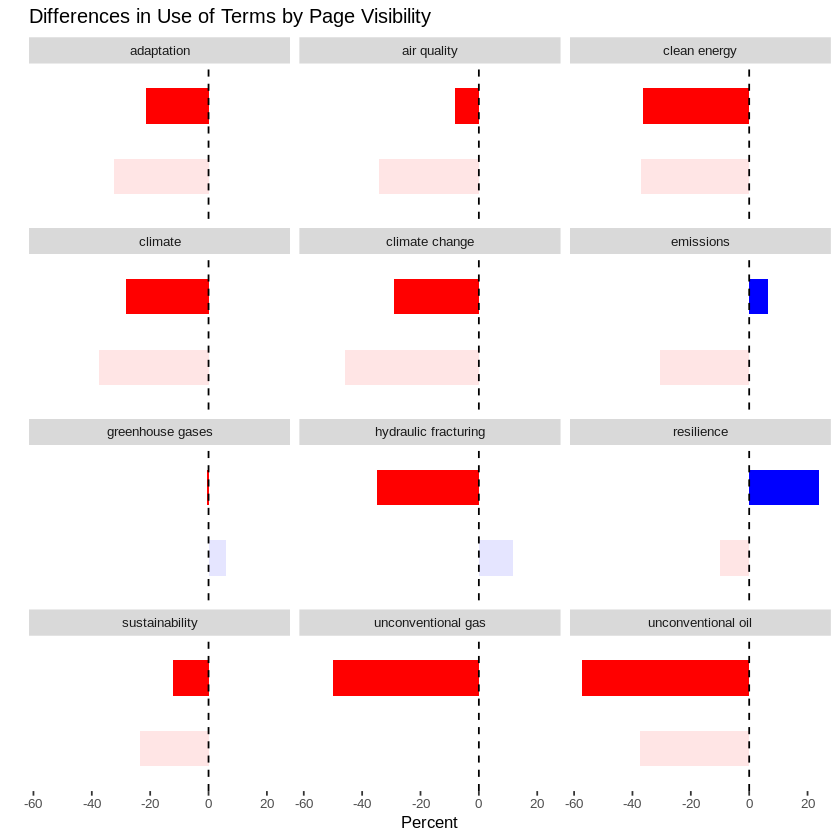

In [36]:
depth <- final[order(-final$Percent),]

pal <- c("red", "blue")

p<-ggplot(depth, aes(x=Visibility, y=Percent, alpha=Viz, fill = Percent>0)) + 
  geom_bar(position="dodge", stat="identity", width = .5) +
  scale_fill_manual(values = pal) +
  geom_hline(yintercept=0, size=.5, linetype="dashed") +
  ggtitle("Percent Change in Use of Terms by Page Visibility") + 
  facet_wrap(~Term, ncol=3) +
  coord_flip() +
  xlab("") +  
  scale_x_discrete(breaks=NULL, labels=NULL)+
  theme(text=element_text(size=10),panel.background = element_rect(fill='white'), 
        legend.position="none", axis.text.y=element_blank(), panel.grid.major.y = element_blank(), 
        panel.grid.minor.y=element_blank(), panel.grid.minor.x=element_blank(), panel.grid.major.x=element_blank())

p

ggsave(filename = "fig8.png", p,
    width = 10, height = 8, dpi = 300, units = "in", device='png') # Saves the figure to the "Files" in Colab

## Figure 9
This figure shows changes in the use of “climate change” by agency and page visibility. More opaque bars represent more visible pages; more transparent bars represent less visible ones. Blue indicates additions; red represents removals.

In [37]:
i=9 # "Climate Change"

# more visible
by.org<-urls_moreviz%>% group_by(org) %>%summarise(num_of_pages=n())
by.org<-by.org[!(by.org$org == "Other"),] # Remove other agencies
    
d<-cbind(urls_moreviz[c(1,8)], first_moreviz[i], combined_moreviz[i])
colnames(d)<-c("url","org", "obama", "change")
d<-d[which(d$obama > 0),] # Need to limit to Obama > 0 to do % change calculation across agencies with few/zero original uses

h<-d%>% group_by(org) %>%summarise(Percent = ((sum(change)/sum(obama))*100), Pages = n()) 
h<-merge(h, by.org, by = "org")
h$Visibility <- c("more visible pages")
h$Viz <- 1
colnames(h)[1]<-c("Agency")


# less visible
by.org<-urls_lessviz%>% group_by(org) %>%summarise(num_of_pages=n())
by.org<-by.org[!(by.org$org == "Other"),] # Remove other agencies

d<-cbind(urls_lessviz[c(1,8)], first_lessviz[i], combined_lessviz[i])
colnames(d)<-c("url","org", "obama", "change")
d<-d[which(d$obama > 0),] # Need to limit to Obama > 0 to do % change calculation across agencies with few/zero original uses

l<-d %>% group_by(org) %>% summarise(Percent = ((sum(change)/sum(obama))*100), Pages = n()) 
l<-merge(l, by.org, by = "org")
l$Visibility <- c("less visible pages")
l$Viz <- .5
colnames(l)[1]<-c("Agency")

depth.agency<-rbind(h, l)

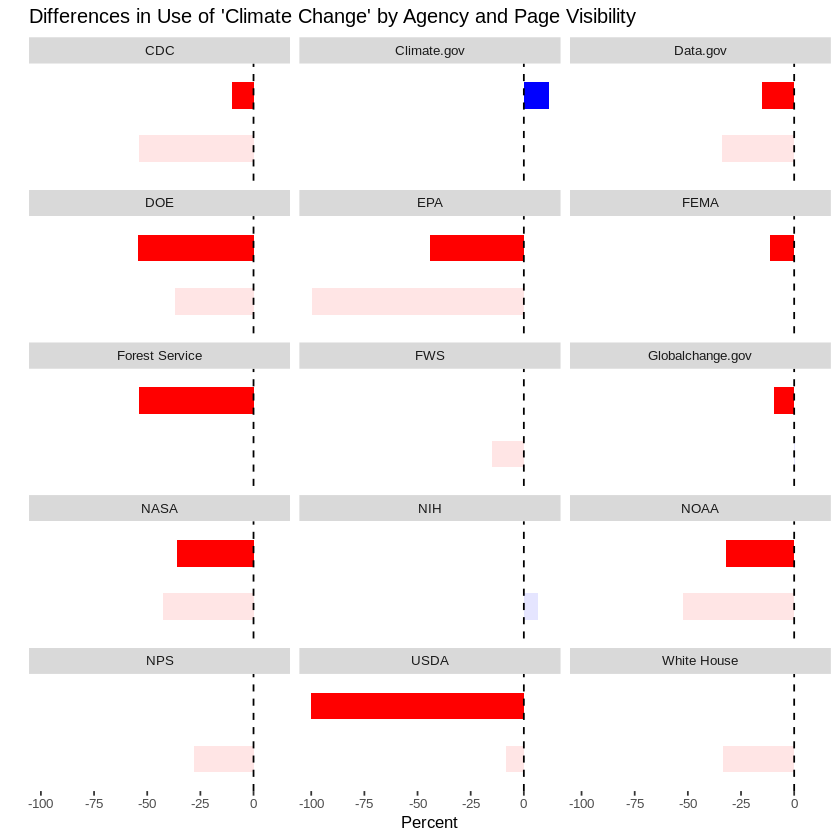

In [38]:
depth.agency <- depth.agency[order(-depth.agency$Percent),]

depth.agency <- depth.agency[which(depth.agency$Pages > 15),] # Focus on the agencies where the term has been used somewhat often (i.e. on more than 15 pages)

pal <- c("red", "blue")

p<-ggplot(depth.agency, aes(x=Visibility, y=Percent, alpha=Viz, fill = Percent>0)) + 
  geom_bar(position="dodge", stat="identity", width = .5) +
  scale_fill_manual(values = pal) +
  geom_hline(yintercept=0, size=.5, linetype="dashed") +
  ggtitle("Percent Change in Use of 'Climate Change' by Agency and Page Visibility") + 
  facet_wrap(~Agency, ncol=3) + 
  coord_flip() +
  xlab("") +  
  scale_x_discrete(breaks=NULL, labels=NULL)+
  theme(text=element_text(size=10),panel.background = element_rect(fill='white'), 
        legend.position="none", axis.text.y=element_blank(), panel.grid.major.y = element_blank(), 
        panel.grid.minor.y=element_blank(), panel.grid.minor.x=element_blank(), panel.grid.major.x=element_blank()) 

p
ggsave(filename = "fig9.png", p,
    width = 10, height = 8, dpi = 300, units = "in", device='png') # Saves the figure to the "Files" in Colab